In [2]:
# Machine Learning Homework 3 -- Question 1
# Dominic Ridley

In [3]:
import scipy.io as spio
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sys
import warnings
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from math import log
import numpy as np
from numpy import isneginf
np.seterr(divide='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
dtrain_data = spio.loadmat('d_train.mat')['data']
dtrain_labels = spio.loadmat('d_train.mat')['labels']

dtest_data = spio.loadmat('d_test.mat')['data']
dtest_labels = spio.loadmat('d_test.mat')['labels']

dtrain500_data = spio.loadmat('d_train500.mat')['data']
dtrain500_labels = spio.loadmat('d_train500.mat')['labels']

dtrain1k_data = spio.loadmat('d_train1000.mat')['data']
dtrain1k_labels = spio.loadmat('d_train1000.mat')['labels']

dtrain10k_data = spio.loadmat('d_train10000.mat')['data']
dtrain10k_labels = spio.loadmat('d_train10000.mat')['labels']

In [5]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
# Used to plot clearly over GMMs

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [6]:
def tenFoldCrossVal(data, labels):
    
    
    #Attach labels to data
    dtrain = np.concatenate((data.T, labels.T), axis=1)
    x_size = len(dtrain)
    
    #Shuffle the data
    np.random.shuffle(dtrain)
    
    c1, c2, c3 = [], [], []
    for sample in dtrain:
        if sample[2] == 1:
            c1.append(sample)
        if sample[2] == 2:
            c2.append(sample)
        if sample[2] == 3:
            c3.append(sample)
    
    all_classes = [np.array(c1), np.array(c2), np.array(c3)]
    class_priors = [len(c1)/x_size, len(c2)/x_size, len(c3)/x_size]
    
    class_parameters = []
    for idx, c in enumerate(all_classes):

        c_class = all_classes[idx]

        #Split the data in 10 batches
        all_batch_sizes = [10, 9, 11, 12, 8, 7, 6, 13]
        for b in all_batch_sizes:
            if len(c) % b == 0:
                sizeBatches = b
                break;
                
        #print(sizeBatches)
        sizeBatches = 10
        batches = np.array_split(c_class, sizeBatches)

        #Shuffle the batches
        #np.random.shuffle(batches)

        c_bic = []
        for test_idx, test_batch in enumerate( batches ):

            test_set = batches[test_idx]
            training_set = np.delete(batches, test_idx, 0)
            training_set = np.concatenate(training_set)
            
            train_data = training_set[:, :2]
            train_labels = training_set[:, 2:]
            
            test_data =  test_set[:, :2]
            test_labels = test_set[:, 2:]
            
            #train_data = normalize(train_data, norm='l1', axis=0)
            #test_data = normalize(test_data)
            
            #Plot Training Data
            #plt.figure()
            #for idx, i in enumerate(train_data):
            #    plt.plot(i[0], i[1], 'r.')
                
            #Choosing Number of Components
            n_components = np.arange(1, 15)
            
            models = [GaussianMixture(n, 
                                     covariance_type='full',
                                     init_params='kmeans',
                                     verbose=0).fit(train_data)
                    for n in n_components]
            
            test_models = [models[n].fit(train_data) for n in range(len(models))]
            
            bic_scores = [m.bic(train_data) for m in models]
            c_bic.append(bic_scores)
            
        #Plot BIC vs # of Components
        plt.figure()
        plt.plot(n_components, c_bic[0], label='BIC')
        plt.title('BIC vs. Number of Components')
        plt.legend(loc='best')
        plt.ylabel('BIC score');
        plt.xlabel('n_components');
        c_bic = np.array([c_bic])
        plt_name = str(np.random.randint(1000)) + 'BIC' + str(idx) + '.png'
        plt.savefig(plt_name)   
        
        #Average Results from all batches
        c_bic = np.mean(c_bic, axis = 1)
        
        #Choose lowest BIC score
        print(len(n_components))
        c_component = n_components[np.argmin(c_bic)] - 1
        print(c_component)
        #Plot Class GMM
        plt.figure()
        plot_gmm(models[c_component-1], train_data)
        
        cc_p = {'n_components': c_component + 1,
                'c_means': models[c_component].means_,
                'c_weights': models[c_component].weights_,
                'c_covs': models[c_component].covariances_}
        
        class_parameters.append(cc_p)
        
    
    return class_priors, class_parameters   
            

In [7]:
def fitFinalModel(class_priors, class_params, test_data):
    
    nClasses = 3
    class_pdfs = []
    total_comp = sum([class_params[i]['n_components'] for i in range(nClasses)])
    for i in range(nClasses):
        
        currentClass = class_params[i]
        nComponents = currentClass['n_components']
        sum_class_pdf = np.zeros(len(test_data))
        
        component_pdfs = []
        
        #Calculate sum of all component pdfs
        for c in range(nComponents):
            comp_pdf = currentClass['c_weights'][c] * multivariate_normal.pdf(test_data, 
                                                             currentClass['c_means'][c],
                                                             currentClass['c_covs'][c])
            sum_class_pdf = sum_class_pdf + comp_pdf
            component_pdfs.append(comp_pdf)
            
        #sum_class_pdf = np.array([sum_class_pdf])
        #Divide each component pdf by the sum of all component pdfs
        #for c in range(nComponents):
        #    component_pdfs[c] = np.divide(component_pdfs[c], sum_class_pdf)
            
        #print(np.array(component_pdfs).T)
        #print((class_priors[i] * np.array(component_pdfs)).T)
        #class_pdfs.append( np.sum(class_priors[i] * np.array(component_pdfs), axis=0) )
        class_probs = ( class_priors[i] * np.array(component_pdfs)).T
        class_pdfs.append(class_probs)

    class_pr = np.concatenate(class_pdfs, axis=1)
    labels = np.argmax(class_pr, axis=1)
    
    c_ranges = [class_params[0]['n_components'], 
                class_params[0]['n_components'] + class_params[1]['n_components'],
                class_params[0]['n_components'] + class_params[1]['n_components'] + class_params[2]['n_components']]
    for i, sample in enumerate(test_data):
        if (labels[i] >= 0) and (labels[i] < c_ranges[0]):
            plt.plot(sample[0], sample[1], 'r.')
            labels[i] = 1
        elif (labels[i] >= c_ranges[0]) and (labels[i] < c_ranges[1]) :
            plt.plot(sample[0], sample[1], 'b.')
            labels[i] = 2
        elif (labels[i] >= c_ranges[1]) and (labels[i] < c_ranges[2]):
            plt.plot(sample[0], sample[1], 'g.')
            labels[i] = 3
    plt_name = str(np.random.randint(1000)) + 'R1.png'
    plt.savefig(plt_name)       
    return labels

14
13
14
12
14
13


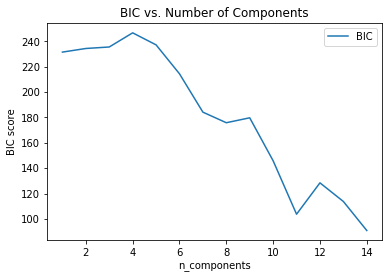

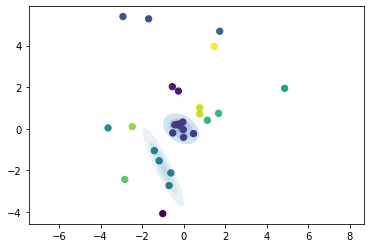

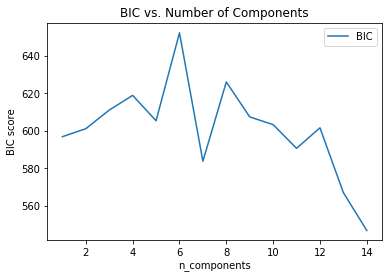

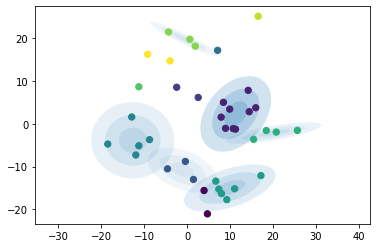

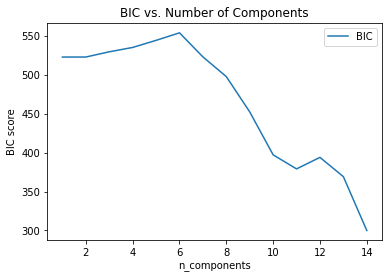

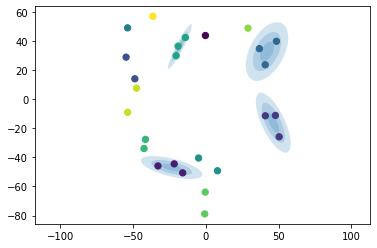

In [20]:
class_priors, class_params = tenFoldCrossVal(dtrain_data, dtrain_labels)

In [ ]:
#test_data = normalize(dtrain1k_data.T, norm='l1', axis=0)
labels = fitFinalModel(class_priors, class_params, dtest_data.T)

In [18]:
accuracy = accuracy_score(dtest_labels.T, labels.T)
print(accuracy)

error = 0
for i in range(len(dtest_labels.T)):
    if dtest_labels.T[i] != labels.T[i]:
        error += 1

print(float(error)/len(dtest_labels.T))

0.9679
321.0
0.0321
